# Portfolio optimization under dominance constraints

The problem solved here comes from Example 1 in [Xue et al. (2020)](https://www.aimsciences.org/article/doi/10.3934/jimo.2019071):

$$
\begin{equation*}
    \min_{z} \ \ -\mathbb{E}_P[G_2(\xi)] \ \ \
    \mathrm{s.t.} \ \ G_2(\xi) \succeq_2 G_1(\xi), \ 1\leq z \leq 2
\end{equation*}
$$

where $\xi \in \mathbb{R} \sim P$ is drawn uniformly from $[0,1]$, the benchmark portfolio is defined as:

$$
\begin{equation*}
    G_1(\xi) = 
    \begin{cases}
        \frac{i}{20} &\xi \in [0.05 \times i, 0.05 \times (i+1)) \ \ \ \ i=0, \ldots, 19\\
        1 &\xi=1
    \end{cases}
\end{equation*}
$$

and the optimization is over the parametrized portfolio $G_2(\xi) := G(\xi;z) = z \xi$.

$Y_2 \succeq_2 Y_1$ denotes 2nd order stochastic dominance, which holds if and only if $\mathbb{E}[(\eta-Y_2)_{+}] \leq \mathbb{E}[(\eta - Y_1)_{+}]$ for any $\eta \in \mathbb{R}$, or equivalently, if $\mathbb{E}[\tilde{u}(Y_2)] \geq \mathbb{E}[\tilde{u}(Y_1)]$ for all concave non-decreasing $\tilde{u} : \mathbb{R} \to \mathbb{R}$ ([Dentcheva and Ruszczynski, 2004](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.90.9157&rep=rep1&type=pdf)).

We solve a relaxed version of this constrained optimization and replace the class of **non-decreasing concave** functions with that of **decreasing convex** functions.

This is equivalent to using convex decreasing $u$, i.e. flipping the inequality in the dominance requirement as follows:

$$\mathbb{E}[u(Y_2)] \leq \mathbb{E}[u(Y_1)]$$

In other words $Y_2 \preceq_{dcvx} Y_1$, where $\preceq_{dcvx}$ is the order generated by the class of decreasing convex functions in 1D.

The relaxed problem is therefore:
$$\min_{z}-\mathbb{E}_P[G(z\xi)] + \lambda\sup_{u \in dcvx}\mathbb{E}_P[u(G(z\xi))] - \mathbb{E}_P[u(G_1(\xi))] $$

This can be optimized as the following bilevel optimization problem

$$\min_{z}-\mathbb{E}_P[G(z\xi)] + \lambda[\mathbb{E}_P[u(G(z\xi))] - \mathbb{E}_P[u(G_1(\xi))]] $$

and
 
$$\min_{u \in dcvx} \mathbb{E}_P[u(G_1(\xi))] - \mathbb{E}_P[u(G(z\xi))] $$

Finally, $dcvx$ is approximated with 3-layer, fully-connected, input convex max-out networks with non-positive input to hidden weights and non-negative weights for all subsequent layers.

## 0. Imports

In [1]:
import math
import os
import sys

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
from torch import nn
from torch.optim import SGD
from tqdm.notebook import tqdm

In [2]:
seed = 0
pl.seed_everything(seed=seed);

Global seed set to 0


## 1. Modules

In [3]:
class ConvexNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, output_dim=1, max_out=4, bias=False):
        super().__init__()
        max_out_adusted_hidden_dim = hidden_dim // max_out
        self.input_to_hidden = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=bias),
            nn.MaxPool1d(kernel_size=max_out)
        )
        self.main = nn.Sequential(
            nn.Linear(max_out_adusted_hidden_dim, hidden_dim, bias=bias),
            nn.MaxPool1d(kernel_size=max_out),
            nn.Linear(max_out_adusted_hidden_dim, output_dim, bias=bias)
        )
        self.project_params_for_decreasing_cvxty()
    
    def forward(self, x):
        hidden = self.input_to_hidden(x)
        return self.main(hidden)
    
    def project_params_for_decreasing_cvxty(self):
        for module in self.input_to_hidden.modules():
            if module and hasattr(module, 'weight'):
                with torch.no_grad():
                    module.weight.data.clip_(-torch.inf, 0)
        for module in self.main.modules():
            if module and hasattr(module, 'weight'):
                with torch.no_grad():
                    module.weight.data.relu_()

    def get_weight_norms(self):
        param_norm = 0
        numel = 0
        for name, module in self.named_modules():
            param_norm = 0
            numel = 0
            if name == '':
                continue
            for param in module.parameters():
                if param.requires_grad:
                    with torch.no_grad():
                        param_norm += param.norm(2).detach().item() ** 2
                        numel += param.numel()
        return math.sqrt(param_norm) / numel
                    
    def test_convexity(self, batch_size=64, eps=1e-6):
        x = torch.randn((batch_size, 1))
        with torch.no_grad(): 
            # Sample lambda uniformly
            lmbds = torch.rand((batch_size, 1))

            # Shuffle indices to randomly select images
            indices1 = torch.randperm(x.shape[0])
            indices2 = torch.randperm(x.shape[0])

            # Check that `f(lambda x + (1-lambda)y) <= lambda f(x) + (1-lambda) f(y)`
            convex_combo_of_inputs = self(lmbds * x[indices1] + (1 - lmbds) * x[indices2])
            convex_combo_of_outputs = lmbds * self(x[indices1]) + (1 - lmbds) * self(x[indices2])
            return torch.sum(convex_combo_of_inputs <= convex_combo_of_outputs + eps).item() / batch_size

## 2. Optimization loop
In the notation below, we use $Y$ to denote the benchmark.

In [4]:
def sample_ξ_Y(batch_size):
    ξ = torch.rand((bsz, 1))
    Y = torch.floor(ξ*20) / 20
    return ξ, Y

def optimization_loop(z, u, z_opt, u_opt, choquet_weight, iterations, batch_size):
    pbar = tqdm(range(iterations), desc='Iter')
    z_steps, u_steps = 0, 0
    steps_log, z_log = [], []
    for i in pbar:
        # Alternate training z and u
        if i % 2:
            u.eval()
        else:
            u.train()

        # Sample ξ and calculate Y(ξ)
        ξ, Y = sample_ξ_Y(batch_size)
        
        # Calculate objectives
        portfolio = z*ξ
        portfolio_objective = -portfolio.mean()
        u_Y = u(Y).mean()
        u_G = u(portfolio).mean()
        choquet_objective = u_G - u_Y
        
        # Take gradient steps: alternate training z and u
        if i % 2:  # optimize z
            optimization_objective = portfolio_objective + choq_weight*choquet_objective
            z_opt.zero_grad()
            optimization_objective.backward()
            z_opt.step()
            z.data.clip_(1, 2)
            z_steps += 1
            steps_log.append(i)
            z_log.append(z.data.item())
        else:  # optimize u
            choquet_objective_for_u = -choquet_objective
            u_opt.zero_grad()
            choquet_objective_for_u.backward()
            u_opt.step()
            u.project_params_for_decreasing_cvxty()       
            u_steps += 1
        
        # Test u convexity
        cvxty = u.test_convexity(batch_size=batch_size)
        
        # Log values to pbar
        with torch.no_grad():
            postfix_str = f'G(ξ,z): {portfolio_objective.item():0.2f}, ' + \
                          f'z: {z.data.item():0.2f}, ' + \
                          f'u(Y): {u_Y.item():0.2f}, ' + \
                          f'u(G(ξ,z)): {u_G.item():0.2f}, ' + \
                          f'cvx: {cvxty:0.2f}'
            pbar.set_postfix_str(postfix_str)
        pbar.set_description(f'u: {u_steps:,d}, z: {z_steps:,d}')

    return {'portfolio': portfolio_objective.item(), 'choquet': choquet_objective.item(),
            'steps_log': steps_log, 'z_log': z_log}

## 3. Run optimization

In [5]:
# Hyperparams
u_hidden_dim = 32
u_max_out = 4
u_bias = True
choq_weight = 1
bsz = 512
steps = 5000
u_lr = 1e-3
z_lr = 1e-3

In [6]:
# Models and optimizer
u = ConvexNN(hidden_dim=u_hidden_dim, max_out=u_max_out, bias=u_bias)
u_opt = SGD(params=u.parameters(), lr=u_lr, maximize=False)

z = nn.Parameter(torch.ones(1))
z_opt = SGD(params=[z], lr=z_lr, maximize=False)

In [7]:
# Run loop
opt_output = optimization_loop(z=z, u=u, z_opt=z_opt, u_opt=u_opt,
                               choquet_weight=choq_weight, iterations=steps, batch_size=bsz);

Iter:   0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
# Display results
u.eval()
ξ_val, Y = sample_ξ_Y(bsz*4)
G = (z*ξ_val)
print(f'z           : {z.data.item():0.4f}')
print(f'E[G(ξ,z)]   : {G.mean().item():0.4f}')
print(f'E[Y(ξ)]     : {Y.mean().item():0.4f}')
print(f'E[u(G(ξ,z))]: {u(G).mean().item():0.4f}')
print(f'E[u(Y)]     : {u(Y).mean().item():0.4f}')

z           : 2.0000
E[G(ξ,z)]   : 1.0424
E[Y(ξ)]     : 0.4964
E[u(G(ξ,z))]: -0.1116
E[u(Y)]     : -0.1058


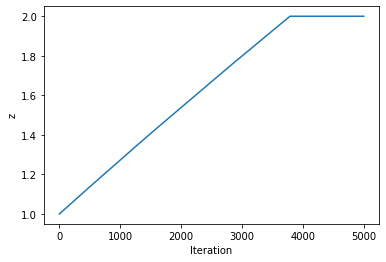

In [9]:
# Plot z
plt.plot(opt_output['steps_log'], opt_output['z_log'])
plt.xlabel('Iteration')
plt.ylabel('z')
plt.show()